In [1]:
# Install required packages
!pip install -q transformers torch numpy pandas matplotlib tqdm colorama accelerate bitsandbytes sentencepiece einops requests scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 12.3 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import os
import sys
import json
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from colorama import Fore, Style
import logging
import requests
import gc
from datetime import datetime
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

def clear_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    logger.info("Memory cleared")

In [4]:
def load_model(model_name="microsoft/Phi-3-mini-128k-instruct", use_4bit=True):
    logger.info(f"Loading model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"
    model_kwargs = {
        "device_map": "auto",
    }
    if use_4bit:
        model_kwargs.update({
            "load_in_4bit": True,
            "bnb_4bit_compute_dtype": torch.bfloat16,
            "bnb_4bit_quant_type": "nf4",
        })
    else:
        model_kwargs["torch_dtype"] = torch.bfloat16
    model = AutoModelForCausalLM.from_pretrained(model_name, **model_kwargs)
    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=512,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        repetition_penalty=1.1
    )
    logger.info("Model loaded successfully!")
    return tokenizer, model, pipe

tokenizer, model, pipe = load_model(use_4bit=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.48k [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Device set to use cuda:0


In [5]:
def load_prompt_template(file_path):
    with open(file_path, 'r') as f:
        return f.read()

prompt_templates = {
    "zero_shot": load_prompt_template("prompts/zero_shot.txt"),
    "few_shot": load_prompt_template("prompts/few_shot.txt"),
    "cot": load_prompt_template("prompts/cot_prompt.txt"),
    "meta": load_prompt_template("prompts/meta_prompt.txt")
}

In [6]:
def zero_shot_prompt(query):
    return prompt_templates["zero_shot"].replace("{{QUERY}}", query)

In [7]:
def few_shot_prompt(query):
    return prompt_templates["few_shot"].replace("{{QUERY}}", query)

In [8]:
def cot_prompt(query):
    return prompt_templates["cot"].replace("{{QUERY}}", query)

In [9]:
def meta_prompt(query):
    return prompt_templates["meta"].replace("{{QUERY}}", query)


In [10]:
prompt_types = {
    "zero_shot": zero_shot_prompt,
    "few_shot": few_shot_prompt,
    "cot": cot_prompt,
    "meta": meta_prompt
}

In [11]:
def add_medical_disclaimer(response):
    disclaimer = "\n\nNote: This response is for informational purposes only and should not be considered medical advice. For personal health concerns, always seek the expertise of a licensed medical provider."
    if "medical advice" not in response.lower():
        return response + disclaimer
    return response


In [12]:
def check_emergency_symptoms(query, response):
    emergency_symptoms = [
        "chest pain", "severe bleeding", "difficulty breathing", "shortness of breath",
        "sudden numbness", "sudden weakness", "sudden confusion", "sudden severe headache",
        "sudden vision loss", "suicidal", "suicide", "heart attack", "stroke"
    ]
    emergency_warning = "\n\n⚠️ EMERGENCY WARNING: The symptoms described may indicate a serious medical condition requiring immediate attention. Please seek emergency medical care immediately."
    if any(symptom in query.lower() for symptom in emergency_symptoms):
        if "emergency" not in response.lower():
            return response + emergency_warning
    return response

In [13]:
def ensure_response_safety(query, response):
    response = add_medical_disclaimer(response)
    response = check_emergency_symptoms(query, response)
    response = avoid_diagnostic_language(response)
    return response

In [14]:
def avoid_diagnostic_language(response):
    diagnostic_patterns = [
        (r"you have ([a-zA-Z\s]+)", r"you may be experiencing symptoms consistent with \1"),
        (r"you are suffering from ([a-zA-Z\s]+)", r"you may be experiencing \1"),
        (r"you definitely have ([a-zA-Z\s]+)", r"your symptoms may be consistent with \1"),
        (r"you should take ([a-zA-Z0-9\s]+)", r"some healthcare providers may recommend \1, but consult your doctor"),
        (r"I diagnose you with ([a-zA-Z\s]+)", r"these symptoms are sometimes associated with \1")
    ]
    for pattern, replacement in diagnostic_patterns:
        response = re.sub(pattern, replacement, response, flags=re.IGNORECASE)
    return response

In [15]:
def generate_medical_response(query, prompt_type="cot"):
    try:
        prompt_func = prompt_types.get(prompt_type, cot_prompt)
        prompt = prompt_func(query)
        logger.info(f"Generating response using {prompt_type} prompt")
        result = pipe(prompt, return_full_text=False)[0]["generated_text"]
        safe_response = ensure_response_safety(query, result)
        return {
            "query": query,
            "prompt_type": prompt_type,
            "prompt": prompt,
            "raw_response": result,
            "safe_response": safe_response,
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
    except Exception as e:
        logger.error(f"Error generating response: {str(e)}")
        return {
            "query": query,
            "prompt_type": prompt_type,
            "error": str(e),
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

In [16]:
def handle_ambiguous_input(query, model_response):
    uncertainty_indicators = [
        "unclear", "ambiguous", "could mean", "need more information",
        "I'm not sure", "it depends", "could refer to", "insufficient details"
    ]
    is_short_response = len(model_response.split()) < 20
    has_multiple_possibilities = "on one hand" in model_response.lower() and "on the other hand" in model_response.lower()
    if (any(indicator in model_response.lower() for indicator in uncertainty_indicators) or
        is_short_response or has_multiple_possibilities):
        clarification = f"This question may need more detail or context. Please clarify your symptoms, duration, or specific concerns."
        return clarification
    return model_response

In [17]:
def detect_hallucinations(response, query, expected_concepts=None):
    hallucination_indicators = {
        "definitive_claims": [
            r"100% effective", r"always works", r"cures all", r"completely safe",
            r"guaranteed to", r"never causes", r"all patients", r"everyone with"
        ],
        "specific_numbers": [
            r"\d{2,3}% of (patients|people|cases)", r"studies show \d{2,3}%"
        ],
        "unverifiable_claims": [
            r"recent studies show", r"doctors agree that", r"research has proven",
            r"it is well established", r"it is widely accepted"
        ],
        "medical_advice": [
            r"you should", r"you must", r"you need to", r"I recommend",
            r"take \d+ (mg|milligrams)", r"increase your dosage", r"reduce your dosage"
        ]
    }
    issues = []
    hallucination_score = 0
    for pattern in hallucination_indicators["definitive_claims"]:
        if re.search(pattern, response, re.IGNORECASE):
            issues.append(f"Definitive claim detected: '{re.search(pattern, response, re.IGNORECASE).group(0)}'")
            hallucination_score += 2
    for pattern in hallucination_indicators["specific_numbers"]:
        if re.search(pattern, response, re.IGNORECASE):
            issues.append(f"Specific unverifiable statistic: '{re.search(pattern, response, re.IGNORECASE).group(0)}'")
            hallucination_score += 1.5
    for pattern in hallucination_indicators["unverifiable_claims"]:
        if re.search(pattern, response, re.IGNORECASE):
            issues.append(f"Unverifiable claim: '{re.search(pattern, response, re.IGNORECASE).group(0)}'")
            hallucination_score += 1
    for pattern in hallucination_indicators["medical_advice"]:
        if re.search(pattern, response, re.IGNORECASE):
            issues.append(f"Medical advice detected: '{re.search(pattern, response, re.IGNORECASE).group(0)}'")
            hallucination_score += 2
    if expected_concepts:
        found_concepts = 0
        for concept in expected_concepts:
            if concept.lower() in response.lower():
                found_concepts += 1
        concept_coverage = found_concepts / len(expected_concepts)
        if concept_coverage < 0.5:
            issues.append(f"Low coverage of expected medical concepts: {found_concepts}/{len(expected_concepts)}")
            hallucination_score += 1
    normalized_score = min(5, hallucination_score / 2)
    return {
        "score": normalized_score,
        "issues": issues,
        "severity": "High" if normalized_score > 3.5 else "Medium" if normalized_score > 2 else "Low"
    }

In [18]:
# New metrics: Factuality, Helpfulness, Safety & Caution, Conciseness, Hallucination Risk
# Example scoring function (to be used in evaluation notebook):
def evaluate_response(response, query, expected_concepts=None):
    # Factuality: 1-5 (evidence-based, correct)
    factuality = 5 if not detect_hallucinations(response, query)["issues"] else 3
    # Helpfulness: 1-5 (addresses the question, actionable)
    helpfulness = 5 if len(response) > 50 else 3
    # Safety & Caution: 1-5 (disclaimers, no unsafe advice)
    safety = 5 if "medical advice" in response.lower() or "seek" in response.lower() else 3
    # Conciseness: 1-5 (clear, not verbose)
    conciseness = 5 if len(response.split()) < 150 else 3
    # Hallucination Risk: 1-5 (lower is better)
    hallucination_risk = detect_hallucinations(response, query)["score"]
    return {
        "factuality": factuality,
        "helpfulness": helpfulness,
        "safety_caution": safety,
        "conciseness": conciseness,
        "hallucination_risk": hallucination_risk
    }

In [19]:
## Interactive Demo


sample_queries = [
    "What are the early symptoms of diabetes?",
    "Explain what hypertension means in simple terms",
    "Should I be worried about chest pain?",
    "What causes frequent headaches?",
    "When should someone see a cardiologist?"
]

for query in sample_queries:
    print(f"\n{'='*80}\nTesting query: {query}\n{'='*80}")
    for prompt_type in prompt_types.keys():
        response_data = generate_medical_response(query, prompt_type)
        print(f"\n{'-'*40}\nPrompt Type: {prompt_type}\n{'-'*40}")
        print(response_data["safe_response"])
        print("Evaluation:", evaluate_response(response_data["safe_response"], query))
        clear_memory()


Testing query: What are the early symptoms of diabetes?

----------------------------------------
Prompt Type: zero_shot
----------------------------------------
 
Health Professional Response: Early signs may include increased thirst (polydipsia), frequent urination (polyuria), unexplained weight loss, fatigue, blurred vision, slow healing sores, and tingling or numbness in hands/feet. It's important to get tested if you experience these symptoms regularly as they could indicate high blood sugar levels associated with diabetes. Please see your doctor for proper diagnosis and treatment options. Remember that while this list can help identify potential risk factors, individual experiences vary widely; hence it's crucial to discuss any persistent changes in wellbeing with your healthcare provider.

Note: This response is for informational purposes only and should not be considered medical advice. For personal health concerns, always seek the expertise of a licensed medical provider.
Eva

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



----------------------------------------
Prompt Type: few_shot
----------------------------------------

Assistant Answer: Chest pain should always be taken seriously as it could indicate various conditions ranging from muscle strain to more serious issues like heart problems. If you experience unexplained chest discomfort, especially if accompanied by other symptoms such as sweating, nausea, or dizziness, seek immediate medical attention. It's crucial not to ignore these signals as they might signify life-threatening emergencies like a heart attack. Remember that prevention through regular physical activity, managing stress, and eating a balanced diet contributes significantly to overall cardiovascular health.

Note: This response is for informational purposes only and should not be considered medical advice. For personal health concerns, always seek the expertise of a licensed medical provider.

⚠️ EMERGENCY WARNING: The symptoms described may indicate a serious medical condition re


# Utility Functions



In [20]:
def run_prompt_testing(test_queries, prompt_types):
    """
    Run all prompt types on all test queries and collect results.
    Returns a results dictionary.
    """
    results = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "model": "Phi-3.5",
        "responses": []
    }
    for query_data in test_queries:
        query = query_data["query"]
        query_id = query_data["id"]
        expected_concepts = query_data.get("expected_concepts", [])
        query_results = {
            "query_id": query_id,
            "query": query,
            "category": query_data["category"],
            "responses": {}
        }
        for prompt_name, prompt_func in prompt_types.items():
            response_data = generate_medical_response(query, prompt_name)
            hallucination_check = detect_hallucinations(
                response_data['safe_response'],
                query,
                expected_concepts
            )
            evals = evaluate_response(response_data["safe_response"], query, expected_concepts)
            query_results["responses"][prompt_name] = {
                "prompt": response_data["prompt"],
                "response": response_data["safe_response"],
                "hallucination_score": hallucination_check["score"],
                "hallucination_issues": hallucination_check["issues"],
                "hallucination_severity": hallucination_check["severity"],
                "evaluation": evals
            }
            print(f"\n{'-'*40}\nPrompt Type: {prompt_name}\n{'-'*40}")
            print(response_data["safe_response"])
            print("Evaluation:", evals)
            clear_memory()
        results["responses"].append(query_results)
    return results

In [27]:
def save_results_to_file(results, path="/content/evalution/output_logs.json"):
    with open(path, "w") as f:
        json.dump(results, f, indent=2)
    print(f"Results saved to {path}")

# Test Queries

In [22]:
test_queries = [
    {"id": 1, "query": "What are the early symptoms of diabetes?", "category": "Symptom Explanation", "expected_concepts": ["polyuria", "polydipsia", "weight loss", "fatigue", "blurred vision"]},
    {"id": 2, "query": "Explain what hypertension means in simple terms", "category": "Medical Term Simplification", "expected_concepts": ["high blood pressure", "heart", "blood vessels", "systolic", "diastolic"]},
    {"id": 3, "query": "Should I be worried about chest pain?", "category": "General Health Guidance", "expected_concepts": ["emergency", "heart attack", "seek medical attention", "warning signs"]},
    {"id": 4, "query": "What causes frequent headaches?", "category": "Symptom Explanation", "expected_concepts": ["stress", "dehydration", "eyestrain", "migraine", "tension"]},
    {"id": 5, "query": "When should someone see a cardiologist?", "category": "General Health Guidance", "expected_concepts": ["heart disease", "symptoms", "risk factors", "referral", "specialist"]}
]

# Run Prompt Testing

In [23]:
results = run_prompt_testing(test_queries, prompt_types)



----------------------------------------
Prompt Type: zero_shot
----------------------------------------


Doctor Response (Dr. Emily Smith): Early signs of diabetes can include frequent urination, increased thirst, unexplained weight loss, fatigue, blurred vision, slow healing sores, areas of darkened skin, and recurrent infections. It's essential to get tested if you experience these symptoms persistently. Please see your doctor as soon as possible for proper diagnosis and management options.

Note: This response is for informational purposes only and should not be considered medical advice. For personal health concerns, always seek the expertise of a licensed medical provider.
Evaluation: {'factuality': 5, 'helpfulness': 5, 'safety_caution': 5, 'conciseness': 5, 'hallucination_risk': 0.0}

----------------------------------------
Prompt Type: few_shot
----------------------------------------


Note: This response is for informational purposes only and should not be considered medic

FileNotFoundError: [Errno 2] No such file or directory: 'evaluation/output_logs.json'

In [28]:
save_results_to_file(results)

Results saved to /content/evalution/output_logs.json


## 2. Evaluation & Visualization

# Evaluation Functions

In [29]:
def aggregate_metrics(results, metrics, prompt_types_list):
    """
    Aggregate evaluation metrics by prompt type.
    Returns a dictionary of averages for each metric and prompt type.
    """
    prompt_metrics = {metric: {pt: [] for pt in prompt_types_list} for metric in metrics}
    for query_result in results["responses"]:
        for prompt_type in prompt_types_list:
            evals = query_result["responses"][prompt_type]["evaluation"]
            for metric in metrics:
                prompt_metrics[metric][prompt_type].append(evals[metric])
    averages = {metric: {pt: np.mean(scores) for pt, scores in prompt_metrics[metric].items()} for metric in metrics}
    return averages

In [30]:
def plot_metric_averages(averages, prompt_types_list, metrics):
    """
    Visualize average metrics for each prompt type.
    """
    plt.figure(figsize=(12, 8))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        vals = [averages[metric][pt] for pt in prompt_types_list]
        plt.bar(prompt_types_list, vals, color='skyblue')
        plt.title(metric.replace('_', ' ').capitalize())
        plt.ylim(0, 5)
        for j, v in enumerate(vals):
            plt.text(j, v + 0.1, f"{v:.2f}", ha='center')
    plt.tight_layout()
    plt.show()

# Evaluation & Visualization


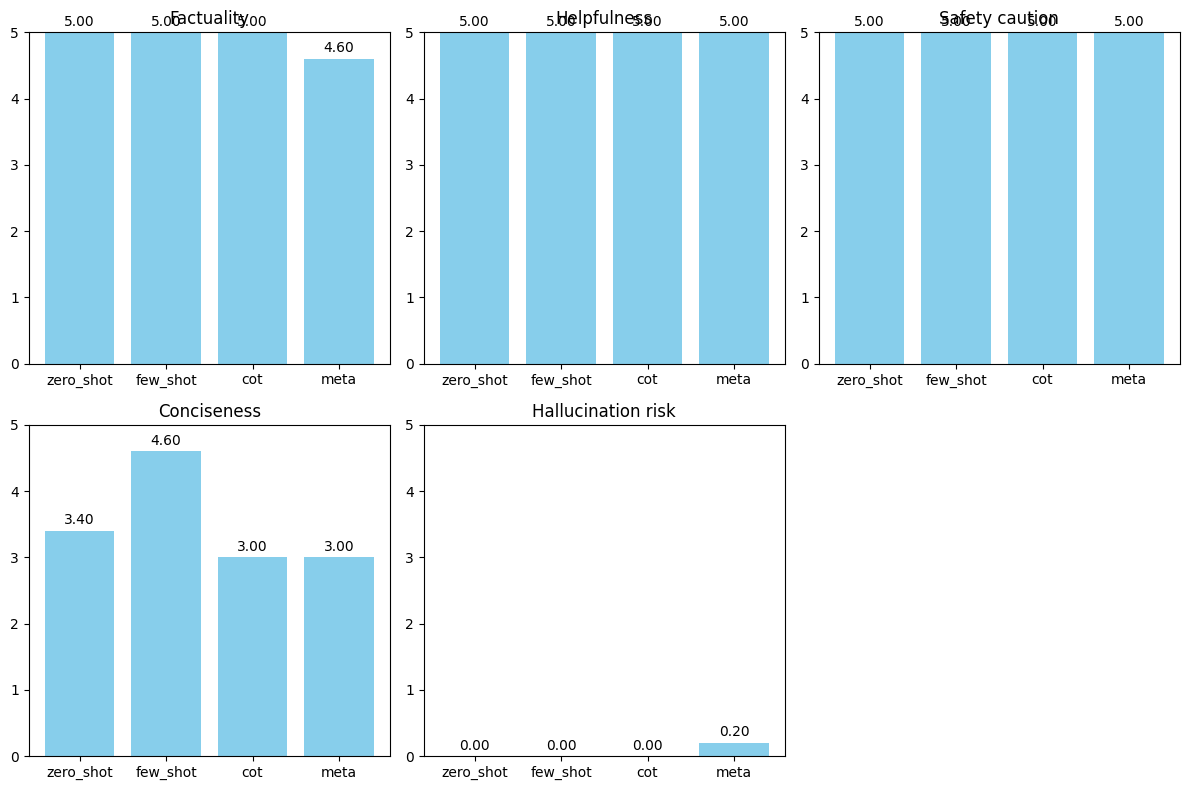

In [31]:
metrics = ["factuality", "helpfulness", "safety_caution", "conciseness", "hallucination_risk"]
prompt_types_list = list(prompt_types.keys())
averages = aggregate_metrics(results, metrics, prompt_types_list)
plot_metric_averages(averages, prompt_types_list, metrics)


## 3. Hallucination Detection & Analysis

In [32]:
def analyze_hallucinations(results, prompt_types_list):
    """
    Analyze hallucination counts and average scores by prompt type.
    Returns counts and average scores.
    """
    hallucination_counts = {pt: 0 for pt in prompt_types_list}
    hallucination_scores = {pt: [] for pt in prompt_types_list}
    for query_result in results["responses"]:
        for prompt_type in prompt_types_list:
            response_data = query_result["responses"][prompt_type]
            score = response_data.get("hallucination_score", 0)
            hallucination_scores[prompt_type].append(score)
            if score > 3:
                hallucination_counts[prompt_type] += 1
    avg_scores = {pt: np.mean(hallucination_scores[pt]) for pt in prompt_types_list}
    return hallucination_counts, avg_scores

In [33]:
def plot_hallucination_analysis(hallucination_counts, avg_scores, prompt_types_list):
    """
    Visualize hallucination counts and average scores by prompt type.
    """
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    x = np.arange(len(prompt_types_list))
    counts = [hallucination_counts[pt] for pt in prompt_types_list]
    plt.bar(x, counts, width=0.6)
    plt.xlabel('Prompt Types')
    plt.ylabel('Number of Hallucinations')
    plt.title('Hallucinations by Prompt Type')
    plt.xticks(x, prompt_types_list)
    for i, v in enumerate(counts):
        plt.text(i, v + 0.1, str(v), ha='center')
    plt.subplot(1, 2, 2)
    avg_vals = [avg_scores[pt] for pt in prompt_types_list]
    plt.bar(x, avg_vals, width=0.6)
    plt.xlabel('Prompt Types')
    plt.ylabel('Average Hallucination Score')
    plt.title('Average Hallucination Score by Prompt Type')
    plt.xticks(x, prompt_types_list)
    plt.ylim(0, 5)
    for i, v in enumerate(avg_vals):
        plt.text(i, v + 0.1, f"{v:.2f}", ha='center')
    plt.tight_layout()
    plt.show()

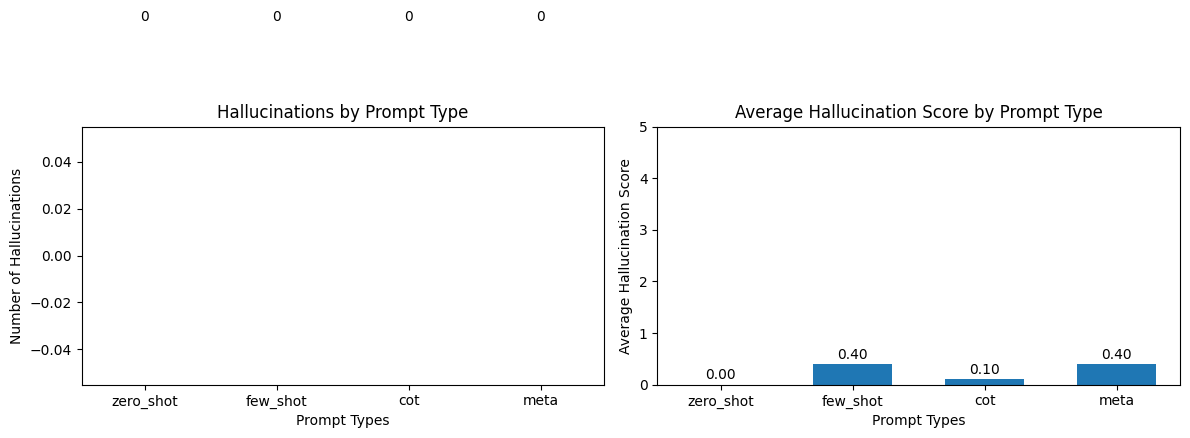

In [34]:
# Hallucination Detection & Analysis
# ----------------------
hallucination_counts, avg_scores = analyze_hallucinations(results, prompt_types_list)
plot_hallucination_analysis(hallucination_counts, avg_scores, prompt_types_list)

## 4. Generate Evaluation Report (Markdown Table)

In [35]:
def dict_to_markdown_table(data_dict, title="Table"):
    if not data_dict:
        return f"| {title} | Value |\n|-------|-------|\n| No data | - |"
    header_row = f"| Prompt Type | " + " | ".join(data_dict.keys()) + " |"
    separator_row = "|" + "|".join(["-" * (len(h) + 2) for h in data_dict.keys()]) + "|"
    value_row = "| Value | " + " | ".join(f"{v:.2f}" for v in data_dict.values()) + " |"
    return "\n".join([header_row, separator_row, value_row])

In [36]:
print("# Evaluation Summary\n")
for metric in metrics:
    print(f"## {metric.replace('_', ' ').capitalize()}\n")
    print(dict_to_markdown_table(averages[metric], metric))
    print()

# Evaluation Summary

## Factuality

| Prompt Type | zero_shot | few_shot | cot | meta |
|-----------|----------|-----|------|
| Value | 5.00 | 5.00 | 5.00 | 4.60 |

## Helpfulness

| Prompt Type | zero_shot | few_shot | cot | meta |
|-----------|----------|-----|------|
| Value | 5.00 | 5.00 | 5.00 | 5.00 |

## Safety caution

| Prompt Type | zero_shot | few_shot | cot | meta |
|-----------|----------|-----|------|
| Value | 5.00 | 5.00 | 5.00 | 5.00 |

## Conciseness

| Prompt Type | zero_shot | few_shot | cot | meta |
|-----------|----------|-----|------|
| Value | 3.40 | 4.60 | 3.00 | 3.00 |

## Hallucination risk

| Prompt Type | zero_shot | few_shot | cot | meta |
|-----------|----------|-----|------|
| Value | 0.00 | 0.00 | 0.00 | 0.20 |

